In [1]:
import pickle as pkl 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import utils
import models
import GraphKernel

In [2]:
path = 'data/'
with open(path + 'training_data.pkl', 'rb') as file: 
    train_graphs = pkl.load(file) 

with open(path + 'test_data.pkl', 'rb') as file: 
    test_graphs = pkl.load(file) 
    
with open(path + 'training_labels.pkl', 'rb') as file: 
    train_labels = pkl.load(file) 

In [3]:

for G in train_graphs:
    for e in G.edges:
        G.edges[e]['labels'] = G.edges[e]['labels'][0] + 1

for G in test_graphs:
    for e in G.edges:
        G.edges[e]['labels'] = G.edges[e]['labels'][0] + 1


In [4]:
one_train = []
zero_train = []
for (i,G) in enumerate(train_graphs):
    if(train_labels[i] == 0):
        zero_train.append(G)
    else:
        one_train.append(G)    

In [5]:
n = 6000
train_graphs = one_train
train_labels = [1]*len(one_train)
for G in zero_train:
    if(len(train_graphs) == n):
        break
    train_graphs.append(G)
    train_labels.append(0)


In [6]:
zero_train = zero_train[n:]
y_zeros = np.zeros(len(zero_train))

In [7]:
len(zero_train)

0

In [8]:
#from grakel import ShortestPath
#gk = ShortestPath(with_labels=True)
#K_train = gk.fit_transform(train_graphs)

randomWalk = GraphKernel.WalkKernel(maxK = 10)  #GraphKernel.WalkKernel(maxK = 3) #GraphKernel.ShortestPath()#
shortestPath = GraphKernel.ShortestPath()
K_train = randomWalk.compute_kernel(train_graphs,train_graphs) #+ shortestPath.compute_kernel(train_graphs,train_graphs) 

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_graphs, train_labels, test_size=0.3, random_state=100,stratify=train_labels)
X_train_K = randomWalk.compute_kernel(X_train,X_train)# + shortestPath.compute_kernel(X_train,X_train)
X_test_K = randomWalk.compute_kernel(X_test,X_train) #+ shortestPath.compute_kernel(X_test,X_train)
K_zero = randomWalk.compute_kernel(zero_train,train_graphs) #+ shortestPath.compute_kernel(zero_train,train_graphs)


100%|██████████| 1800/1800 [02:09<00:00, 13.94it/s]
0it [00:00, ?it/s]


In [9]:
K_train

array([[28.70611471,  6.3624704 , 10.88776475, ...,  2.624     ,
         2.624     ,  3.79136   ],
       [ 6.3624704 , 38.59839005, 11.94840132, ...,  1.6       ,
         2.6493952 ,  3.712     ],
       [10.88776475, 11.94840132, 47.35764756, ...,  2.624     ,
         3.6733952 ,  4.59136   ],
       ...,
       [ 2.624     ,  1.6       ,  2.624     , ...,  8.08347853,
         8.08347853,  8.08347853],
       [ 2.624     ,  2.6493952 ,  3.6733952 , ...,  8.08347853,
        13.01919808,  8.08347853],
       [ 3.79136   ,  3.712     ,  4.59136   , ...,  8.08347853,
         8.08347853, 23.45486923]])

In [41]:
C =  0.05

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

s = []
for i in range(10):
    skf = KFold(n_splits=3, random_state=i, shuffle=True)
    score = cross_val_score(SVC(C = C, kernel='precomputed',  probability=True, class_weight='balanced'), K_train, train_labels, cv=skf, scoring = 'roc_auc')
    s.append(score.reshape(-1))
print(np.mean(s))
s = np.array(s).reshape(-1)
print(s)

0.8791123716356959
[0.86346176 0.90402868 0.87365926 0.90017413 0.87403606 0.88188145
 0.88448247 0.87217643 0.88316115 0.85753423 0.87793108 0.89522057
 0.86067663 0.85981183 0.90644222 0.85892001 0.8631125  0.90549419
 0.8792827  0.88790406 0.87667283 0.87293629 0.89464708 0.87286287
 0.8722971  0.87180285 0.88992674 0.86948235 0.86829325 0.89505837]


In [54]:

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C = C, kernel='precomputed',  probability=True,class_weight='balanced')

# Fit on the train Kernel
clf.fit(K_train, train_labels)

if(K_zero.shape[0] > 0):
    # Predict and test.
    y_pred = clf.predict(K_zero)

    print("Classification accuracy: %0.2f" % accuracy_score(y_zeros, y_pred))

In [55]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
if(K_zero.shape[0] > 0):
    y_pred = clf.predict(K_zero)
    #tn, fp, fn, tp = confusion_matrix(y_train, y_pred,normalize='true').ravel()
    confusion_matrix = confusion_matrix(y_zeros, y_pred,normalize='true')
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    cm_display.plot()
    plt.show()

In [56]:
if(K_zero.shape[0] > 0):
    from sklearn.metrics import plot_roc_curve, auc 
    plot_roc_curve(clf, K_zero, y_zeros)

Classification accuracy: 0.84


C:\Users\aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


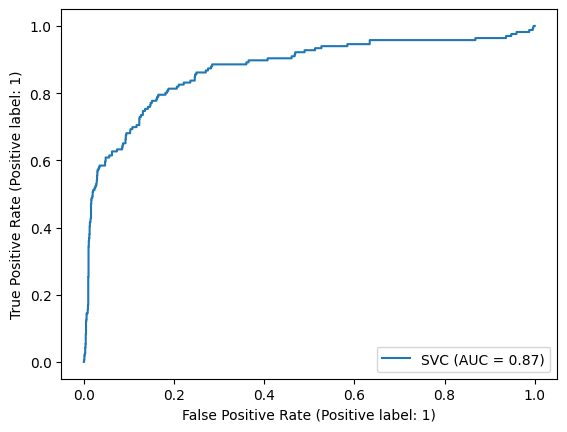

In [57]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C = C, kernel='precomputed',  probability=True,class_weight='balanced')

# Fit on the train Kernel
clf.fit(X_train_K, y_train)

# Predict and test.
y_pred = clf.predict(X_test_K)

print("Classification accuracy: %0.2f" % accuracy_score(y_test, y_pred))
from sklearn.metrics import plot_roc_curve, auc 
plot_roc_curve(clf, X_test_K, y_test)


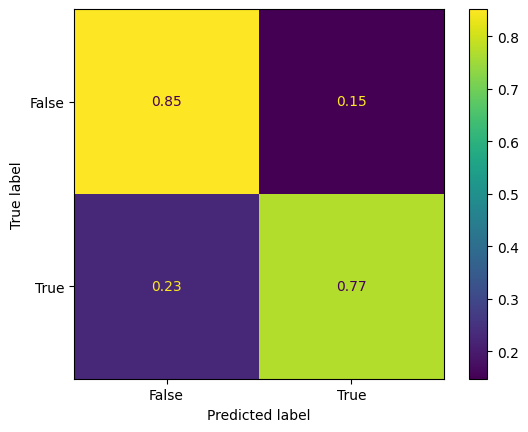

In [58]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y_pred = clf.predict(X_test_K)
#tn, fp, fn, tp = confusion_matrix(y_train, y_pred,normalize='true').ravel()
confusion_matrix = confusion_matrix(y_test, y_pred,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

C:\Users\aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


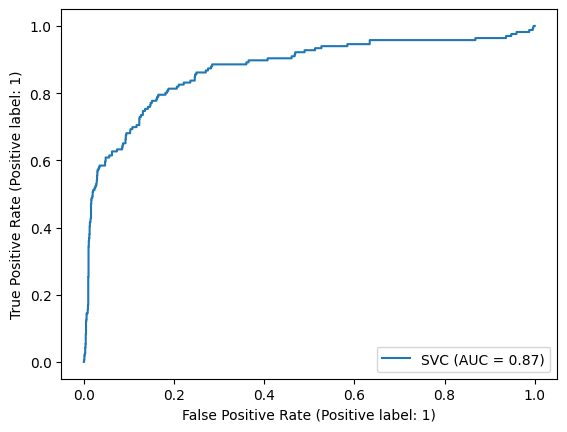

In [59]:
from sklearn.metrics import plot_roc_curve, auc 
plot_roc_curve(clf, X_test_K, y_test)

In [60]:
K_train = randomWalk.compute_kernel(train_graphs,train_graphs)
K_train

100%|██████████| 6000/6000 [11:32<00:00,  8.66it/s]


array([[28.70611471,  6.3624704 , 10.88776475, ...,  2.624     ,
         2.624     ,  3.79136   ],
       [ 6.3624704 , 38.59839005, 11.94840132, ...,  1.6       ,
         2.6493952 ,  3.712     ],
       [10.88776475, 11.94840132, 47.35764756, ...,  2.624     ,
         3.6733952 ,  4.59136   ],
       ...,
       [ 2.624     ,  1.6       ,  2.624     , ...,  8.08347853,
         8.08347853,  8.08347853],
       [ 2.624     ,  2.6493952 ,  3.6733952 , ...,  8.08347853,
        13.01919808,  8.08347853],
       [ 3.79136   ,  3.712     ,  4.59136   , ...,  8.08347853,
         8.08347853, 23.45486923]])

In [61]:
K_test = randomWalk.compute_kernel(test_graphs,train_graphs)

100%|██████████| 2000/2000 [05:59<00:00,  5.56it/s]


In [62]:
y_train = train_labels
y_train = np.array(y_train).reshape(-1)

In [63]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
clf = SVC(C = C, kernel='precomputed',  probability=True,class_weight='balanced')

# Fit on the train Kernel
clf.fit(K_train, y_train)

# Predict and test.
y_pred = clf.predict(K_train)

print("Classification accuracy: %0.2f" % accuracy_score(y_train, y_pred))

Classification accuracy: 0.88


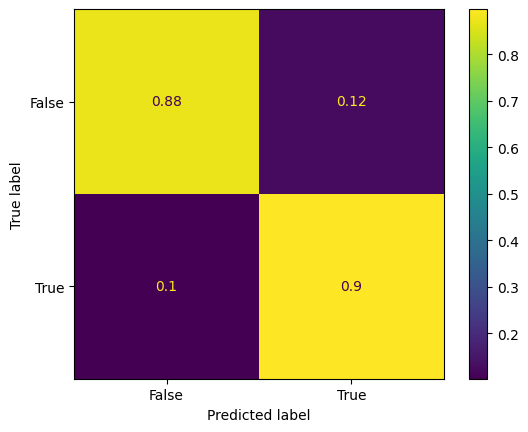

In [64]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
y_pred = clf.predict(K_train)
#tn, fp, fn, tp = confusion_matrix(y_train, y_pred,normalize='true').ravel()
confusion_matrix = confusion_matrix(y_train, y_pred,normalize='true')
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
cm_display.plot()
plt.show()

C:\Users\aliha\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metrics.RocCurveDisplay.from_predictions` or :meth:`sklearn.metrics.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


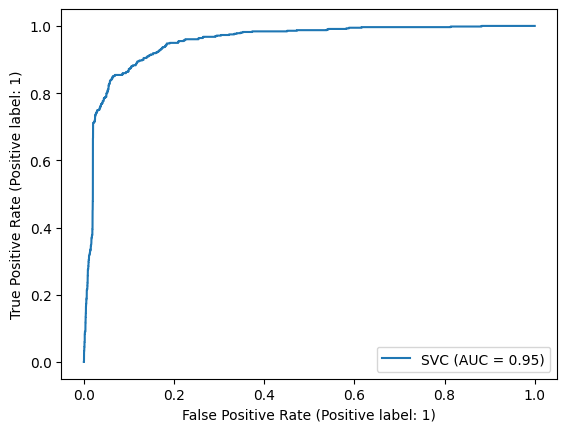

In [65]:
from sklearn.metrics import plot_roc_curve, auc 
plot_roc_curve(clf, K_train, y_train)

In [66]:
y_pred = clf.predict_proba(K_test)[:,1]
y_pred = np.log(y_pred/(1-y_pred))
y_pred

array([-4.6543725 , -3.2519974 , -4.6710081 , ..., -3.68079783,
        0.02698401, -4.31812744])

In [67]:
sub = pd.DataFrame()
sub['Id']= np.arange(1,len(y_pred)+1)
sub['Predicted'] = y_pred
sub.to_csv("submissions/sub.csv",index=False)

In [68]:
y_sub = pd.read_csv("submissions/sub.csv")
y_sub = np.array(y_sub['Predicted'])
y_sub[y_sub< 0 ] = 0
y_sub[y_sub>0] = 1
np.sum(y_sub)/len(y_sub)

0.1075

In [69]:
y_sub = pd.read_csv("submissions/sub_0849.csv")
y_sub = np.array(y_sub['Predicted'])
y_sub[y_sub< 0 ] = 0
y_sub[y_sub>0] = 1
np.sum(y_sub)/len(y_sub)

0.1085